In [1]:
setwd("/home/phucvu/R")

In [2]:
file <- read.csv("adult.data", 
                 header = FALSE, 
                 stringsAsFactors = FALSE, 
                 sep = ",", 
                 strip.white = TRUE,
                 na.strings = c("?","NA"))

names(file) <- c("age", "workclass", "fnlwgt", "education", "education-num", "marital-status", 
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "salary")

In [3]:
df <- data.frame(lapply(file, trimws))
head(df)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,salary
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
cat("Number of missing data in training set:", sum(is.na(df)), "\n")

Number of missing data in training set: 4262 


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


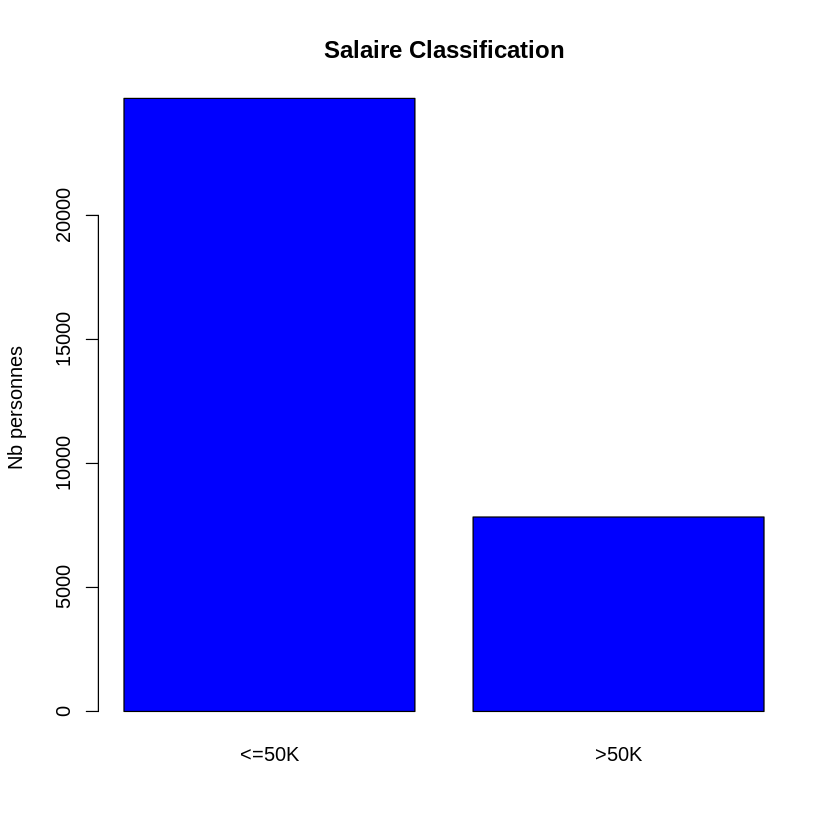

In [5]:
#Statistique de distribution de salaire
library(ggplot2)
barplot(table(df$salary),main="Salaire Classification",col="blue",ylab="Nb personnes")

In [6]:
#Resume de dataframe
summary(df)

      age                   workclass         fnlwgt             education    
 36     :  898   Private         :22696   123011 :   13   HS-grad     :10501  
 31     :  888   Self-emp-not-inc: 2541   164190 :   13   Some-college: 7291  
 34     :  886   Local-gov       : 2093   203488 :   13   Bachelors   : 5355  
 23     :  877   State-gov       : 1298   113364 :   12   Masters     : 1723  
 35     :  876   Self-emp-inc    : 1116   121124 :   12   Assoc-voc   : 1382  
 33     :  875   (Other)         :  981   126675 :   12   11th        : 1175  
 (Other):27261   NA's            : 1836   (Other):32486   (Other)     : 5134  
 education.num                 marital.status            occupation   
 9      :10501   Divorced             : 4443   Prof-specialty : 4140  
 10     : 7291   Married-AF-spouse    :   23   Craft-repair   : 4099  
 13     : 5355   Married-civ-spouse   :14976   Exec-managerial: 4066  
 14     : 1723   Married-spouse-absent:  418   Adm-clerical   : 3770  
 11     : 138

In [7]:
#Check for missing value
colSums(is.na(df))

age      workclass         fnlwgt      education  education.num 
             0           1836              0              0              0 
marital.status     occupation   relationship           race            sex 
             0           1843              0              0              0 
  capital.gain   capital.loss hours.per.week native.country         salary 
             0              0              0            583              0

# **Data Cleaning**

## Regroupement Work Class

In [8]:
table(df$workclass)


     Federal-gov        Local-gov     Never-worked          Private 
             960             2093                7            22696 
    Self-emp-inc Self-emp-not-inc        State-gov      Without-pay 
            1116             2541             1298               14 

On regroupe les facteurs \
On remarque qu'il y a deux groupes particuliers Never-worked et Without-pay, on regroupera ces deux groupes en un groupe plus générale Unemployed (au chomage) \
Les groupes Federal-gov, Local-gov, State-gov sont de nature Governement, on les combine donc en une seul classe Governement \
Les autres groupes Self-emp-inc et Self-emp-not-inc sont des boulot en mode autonome, il vaut mieux qu'on regroupe ce genre en classe Self-employed

In [9]:
#Convertir l'objet factor en character
df$workclass <- as.character(df$workclass)

#Combiner en Unemployed
df$workclass[df$workclass == "Never-worked" | df$workclass == "Without-pay"] <- "Unemployed"

#Combiner en Governement
df$workclass[df$workclass == "Federal-gov" | df$workclass == "Local-gov" | df$workclass == "State-gov"] <- "Governement"

#Combiner en Self-employed
df$workclass[df$workclass == "Self-emp-inc" | df$workclass == "Self-emp-not-inc"] <- "Self-employed"

table(df$workclass)


  Governement       Private Self-employed    Unemployed 
         4351         22696          3657            21 

## Regroupement Statut Marital

In [10]:
table(df$marital.status)


             Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10683                  1025 
              Widowed 
                  993 

On peut réduire ces facteurs en 3 groupes
- Married (Marié)
- Not-Married (Non Marié)
- Never-Married (Célibataire)

In [11]:
df$marital.status <- as.character(df$marital.status)

df$marital.status[df$marital.status == "Married-AF-spouse" |
                       df$marital.status == "Married-civ-spouse" |
                       df$marital.status == "Married-spouse-absent"] <- "Married"

df$marital.status[df$marital.status == "Divorced" |
                       df$marital.status == "Separated" ] <- "Divorced"

df$marital.status[df$marital.status == "Never-married" ] <- "Not-Married"
table(df$marital.status)


   Divorced     Married Not-Married     Widowed 
       5468       15417       10683         993 

Some of the variables are not self-explanatory. The continuous variable fnlwgt represents final weight, which is the number of units in the target population that the responding unit represents. The variable education_num stands for the number of years of education in total, which is a continuous representation of the discrete variable education. The variable relationship represents the responding unit’s role in the family. capital_gain and capital_loss are income from investment sources other than wage/salary.
For simplicity of this analysis, the weighting factor is discarded. Total number of years of education can represent by the highest education level completed. Role in the family can be assessed from gender and marital status. Thus, the following 3 variables are deleted education, relationship, and fnlwgt.

In [12]:
df$educatoin <- NULL
df$fnlwgt <- NULL
df$relationship <- NULL
df$capital.gain <- NULL
df $capital.loss <- NULL

In [14]:
#df = df[!is.na(df$workclass) & !is.na(df$occupation) & !is.na(df$native.country)]
#df = df[!is.na(df$workclass)]
#df = df[!is.na(df$occupation)]
#df = df[!is.na(df$native.country)]
df <- na.omit(df)
colSums(is.na(df))

age      workclass      education  education.num marital.status 
             0              0              0              0              0 
    occupation           race            sex hours.per.week native.country 
             0              0              0              0              0 
        salary 
             0

## **Exploratory Data Analysis**

## Histogramme d'age en fonction de salaire

In [15]:
str(df)

'data.frame':	30162 obs. of  11 variables:
 $ age           : Factor w/ 73 levels "17","18","19",..: 23 34 22 37 12 21 33 36 15 26 ...
 $ workclass     : chr  "Governement" "Self-employed" "Private" "Private" ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education.num : Factor w/ 16 levels "1","10","11",..: 5 5 16 14 5 6 12 16 6 5 ...
 $ marital.status: chr  "Not-Married" "Married" "Divorced" "Married" ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ hours.per.week: Factor w/ 94 levels "1","10","11",..: 35 5 35 35 35 35 8 40 46 35 ...
 $ native.country: Factor w/ 41 levels "Cambodia","Canada",..: 39 39 39 39 5 39 23 39 39 39 ...
 $ salary        : Factor w/ 2 levels "<=50K",">50K": 1 1 1 1 1 1 1 2 2 2 ...
 - attr(*, "na.action")= 'o

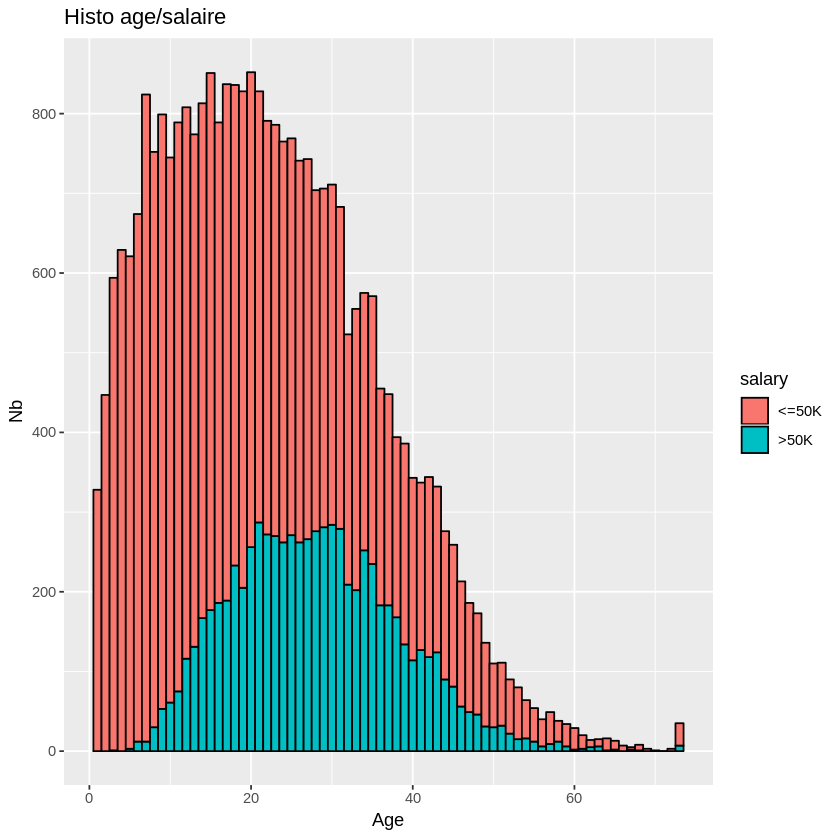

In [16]:
ggplot(df, aes(x=as.numeric(age))) + geom_histogram(aes(group = salary, fill = salary), color = "black",
                                         binwidth = 1) + labs(x="Age", y="Nb", title="Histo age/salaire")

On conserve que la majorité des gens gagne moins de 50k par an. Néanmoins, les gens gagne bien de leur vie >50k sont à la tendance agés

# **Decision Tree**

In [17]:
library(caret) # classification and regression training
library(rpart)
library(rpart.plot)
library(e1071)

Loading required package: lattice


In [18]:
ratio = sample(1:nrow(df), size = 0.25*nrow(df))
testSet = df[ratio,] #Test dataset 25% of total
trainSet = df[-ratio,] #Train dataset 75% of total

Confusion Matrix and Statistics

          Reference
Prediction <=50K >50K
     <=50K  5106  545
     >50K    792 1097
                                          
               Accuracy : 0,8227          
                 95% CI : (0,8139, 0,8312)
    No Information Rate : 0,7822          
    P-Value [Acc > NIR] : < 2,2e-16       
                                          
                  Kappa : 0,5063          
                                          
 Mcnemar's Test P-Value : 1,723e-11       
                                          
            Sensitivity : 0,8657          
            Specificity : 0,6681          
         Pos Pred Value : 0,9036          
         Neg Pred Value : 0,5807          
             Prevalence : 0,7822          
         Detection Rate : 0,6772          
   Detection Prevalence : 0,7495          
      Balanced Accuracy : 0,7669          
                                          
       'Positive' Class : <=50K           
                     

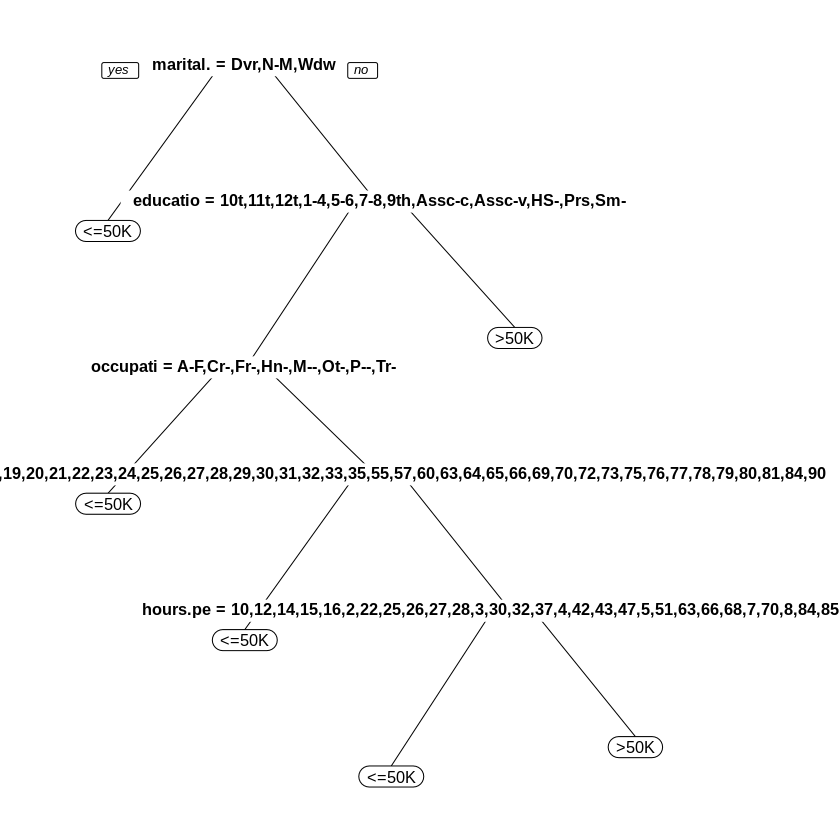

In [19]:
#tree_adult_model<-rpart(salary~.,data = df)

#test_decisionTree$pred_income<-predict(tree_adult_model,test_adult,type = "class")
# an extra argument (type = "class") is required to directly classify prediction into classes

treeModel <- rpart(salary~., data=trainSet, method="class", minbucket=20)
prp(treeModel)
treePredict <- predict(treeModel, testSet, type = "class")
confusionMatrix(testSet$salary, treePredict) # 86% accuracy 